In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy.fft import fft
from scipy.io import loadmat
from PIL import Image
import os

# Display config
np.set_printoptions(suppress=True)
plt.rcParams['figure.dpi'] = 120

print("Notebook initialized.")

Notebook initialized.


In [2]:
def imread_rgb(path):
    img = Image.open(path).convert('RGB')
    return np.array(img)

def rmse(a, b):
    # Crop to min common size
    H = min(a.shape[0], b.shape[0])
    W = min(a.shape[1], b.shape[1])
    if a.ndim == 3:
        C = min(a.shape[2], b.shape[2])
        a_ = a[:H,:W,:C].astype(np.float64)
        b_ = b[:H,:W,:C].astype(np.float64)
    else:
        a_ = a[:H,:W].astype(np.float64)
        b_ = b[:H,:W].astype(np.float64)
    return np.sqrt(np.mean((a_ - b_)**2))

In [3]:
BACKGROUND_PATH = "background.png"
REDCAR_PATH = "redcar.png"
CAMERA_T_MAT_PATH = "CameraT.mat"       # expects a var like 'CameraT' or 'cameraT' or 'T' of length 52

# Common constants
background_img = imread_rgb(BACKGROUND_PATH)
redcar_img = imread_rgb(REDCAR_PATH)

cam = loadmat(CAMERA_T_MAT_PATH)
cameraT = np.array(cam['CameraT']).squeeze()
EXPOSURE_TIME = len(cameraT)


print("Data prepared.")


Data prepared.


In [4]:
# -----------------------
# Blur matrix constructors
# -----------------------
def blur_matrix_from_psf_1d(N, psf_1d):
    # psf_1d length = L; A shape = (N+L, N)
    L = len(psf_1d)
    out_rows = N + L
    A = np.zeros((out_rows, N), dtype=np.float64)
    for j in range(N):
        for k in range(L):
            r = j + k
            if r < out_rows:
                A[r, j] = psf_1d[k]
    return A


In [5]:
# -----------------------
# Image blur synthesizers (horizontal motion)
# -----------------------
def deblur_rowwise_least_squares(blurred, A):
    """
    Solve xA = b for each row (and channel). 
    blurred: (H, Wb, C) with Wb = A.shape[0]
    A: (Wb, W)
    Returns deblurred image (H, W, C).
    """
    H = blurred.shape[0]
    W = A.shape[1]
    C = blurred.shape[2]
    out = np.zeros((H, W, C), dtype=np.float64)

    for c in range(C):
        for r in range(H):
            b = blurred[r, :, c]
            # Ensure length matches A rows
            x, *_ = lstsq(A, b)
            out[r, :, c] = x
    return out


In [ ]:
# ==============================================
# Problem 3: Deblurring with motion-invariant photography
# ==============================================
print("Problem 3: Motion-invariant photography")

H_bg, W_bg = background_img.shape[:2]
car_h, car_w = redcar_img.shape[:2]
car_start_x, car_start_y = 20, 100  # configurable placement

# (a) Static camera, object translates right at 1 px/sec
frames_a = []
for t in range(EXPOSURE_TIME):
    frame = background_img.astype(np.float64).copy()
    x = car_start_x + t
    y = car_start_y
    if x < W_bg and y < H_bg:
        x_end = min(W_bg, x + car_w)
        y_end = min(H_bg, y + car_h)
        fg_x_end = car_w - max(0, x + car_w - W_bg)
        fg_y_end = car_h - max(0, y + car_h - H_bg)
        if (x_end > x) and (y_end > y) and (fg_x_end > 0) and (fg_y_end > 0):
            fg = redcar_img[:fg_y_end, :fg_x_end, :]
            mask = np.any(fg > 0, axis=2)
            region = frame[y:y_end, x:x_end, :]
            region[mask] = fg[mask]
            frame[y:y_end, x:x_end, :] = region
    frames_a.append(frame)

blur_a = np.mean(frames_a, axis=0)

# (b) Motion-invariant: camera motion from CameraT.mat; background shifts by camera motion; 
# relative object translation = camera translation - object translation
frames_b = []

for t in range(EXPOSURE_TIME):
    dx_cam = float(cameraT[t])  # camera translation in pixels at time t

    # Create extended background canvas to allow shifting without cropping
    # We extend by EXPOSURE_TIME on both sides to avoid boundary issues
    pad_left = 52
    extended_width = W_bg + pad_left
    bg_extended = np.zeros((H_bg, extended_width, 3), dtype=np.float64)

    # Place original background in the center
    # Compute shift: positive dx_cam means camera moves right → background shifts right
    s = int(np.round(dx_cam))
    bg_extended[:, s:s + W_bg, :] = background_img

    # Now place the moving car with *relative motion*
    object_translation = t  # object moves at 1 px/sec
    relative_translation = dx_cam - object_translation
    x = int(np.round(car_start_x + relative_translation))
    y = car_start_y

    frame = bg_extended.copy()

    # Paste red car with bounds checking
    if x < W_bg and y < H_bg:
        x_end = min(W_bg, x + car_w)
        y_end = min(H_bg, y + car_h)

        fg_x_start = max(0, -x)
        fg_y_start = max(0, -y)
        fg_x_end = car_w - max(0, x + car_w - W_bg)
        fg_y_end = car_h - max(0, y + car_h - H_bg)

        if fg_x_end > fg_x_start and fg_y_end > fg_y_start:
            fg = redcar_img[fg_y_start:fg_y_end, fg_x_start:fg_x_end, :]
            mask = np.any(fg > 0, axis=2)
            frame_y_start = y + fg_y_start
            frame_x_start = x + fg_x_start
            region = frame[frame_y_start:frame_y_start + fg.shape[0],
                          frame_x_start:frame_x_start + fg.shape[1], :]
            region[mask] = fg[mask]
            frame[frame_y_start:frame_y_start + fg.shape[0],
                  frame_x_start:frame_x_start + fg.shape[1], :] = region

    frames_b.append(frame)

# Final blurred image via averaging
blur_b = np.mean(frames_b, axis=0)

# (c) Compare and comment
print("(c) Static camera: moving object blurred; Motion-invariant: relative blur on object reduced; background shows camera-induced blur.")

# (d) PSF weights: w(x) = 1/x^2 for x in {0.1, 1, 2, ..., 51}, normalize
x_vals = np.concatenate([[0.1], np.arange(1, 52)])
psf = 3.0 / (x_vals**0.5)
psf = psf / (psf.sum() + 1e-12)
print("(d) PSF created and normalized.")

# (e) Use PSF to form blur matrix A_psf
A_psf = blur_matrix_from_psf_1d(W_bg, psf)
print("(e) A_psf formed with shape:", A_psf.shape)

# (f) Deblur blur_b using least squares row-wise with A_psf
print("blur_b shape = ", blur_b.shape)
print("psf shape = ", psf.shape)
rec_b = deblur_rowwise_least_squares(blur_b, A_psf)
print("(f) Deblurring done for motion-invariant case.")

Problem 3: Motion-invariant photography
(c) Static camera: moving object blurred; Motion-invariant: relative blur on object reduced; background shows camera-induced blur.
(d) PSF created and normalized.
(e) A_psf formed with shape: (652, 600)
blur_b shape =  (360, 652, 3)
psf shape =  (52,)
(f) Deblurring done for motion-invariant case.


### Not doing interpolation of backgorund, so the sides will be black only

In [7]:
print(rmse(rec_b, blur_b))

0.1307474300740542


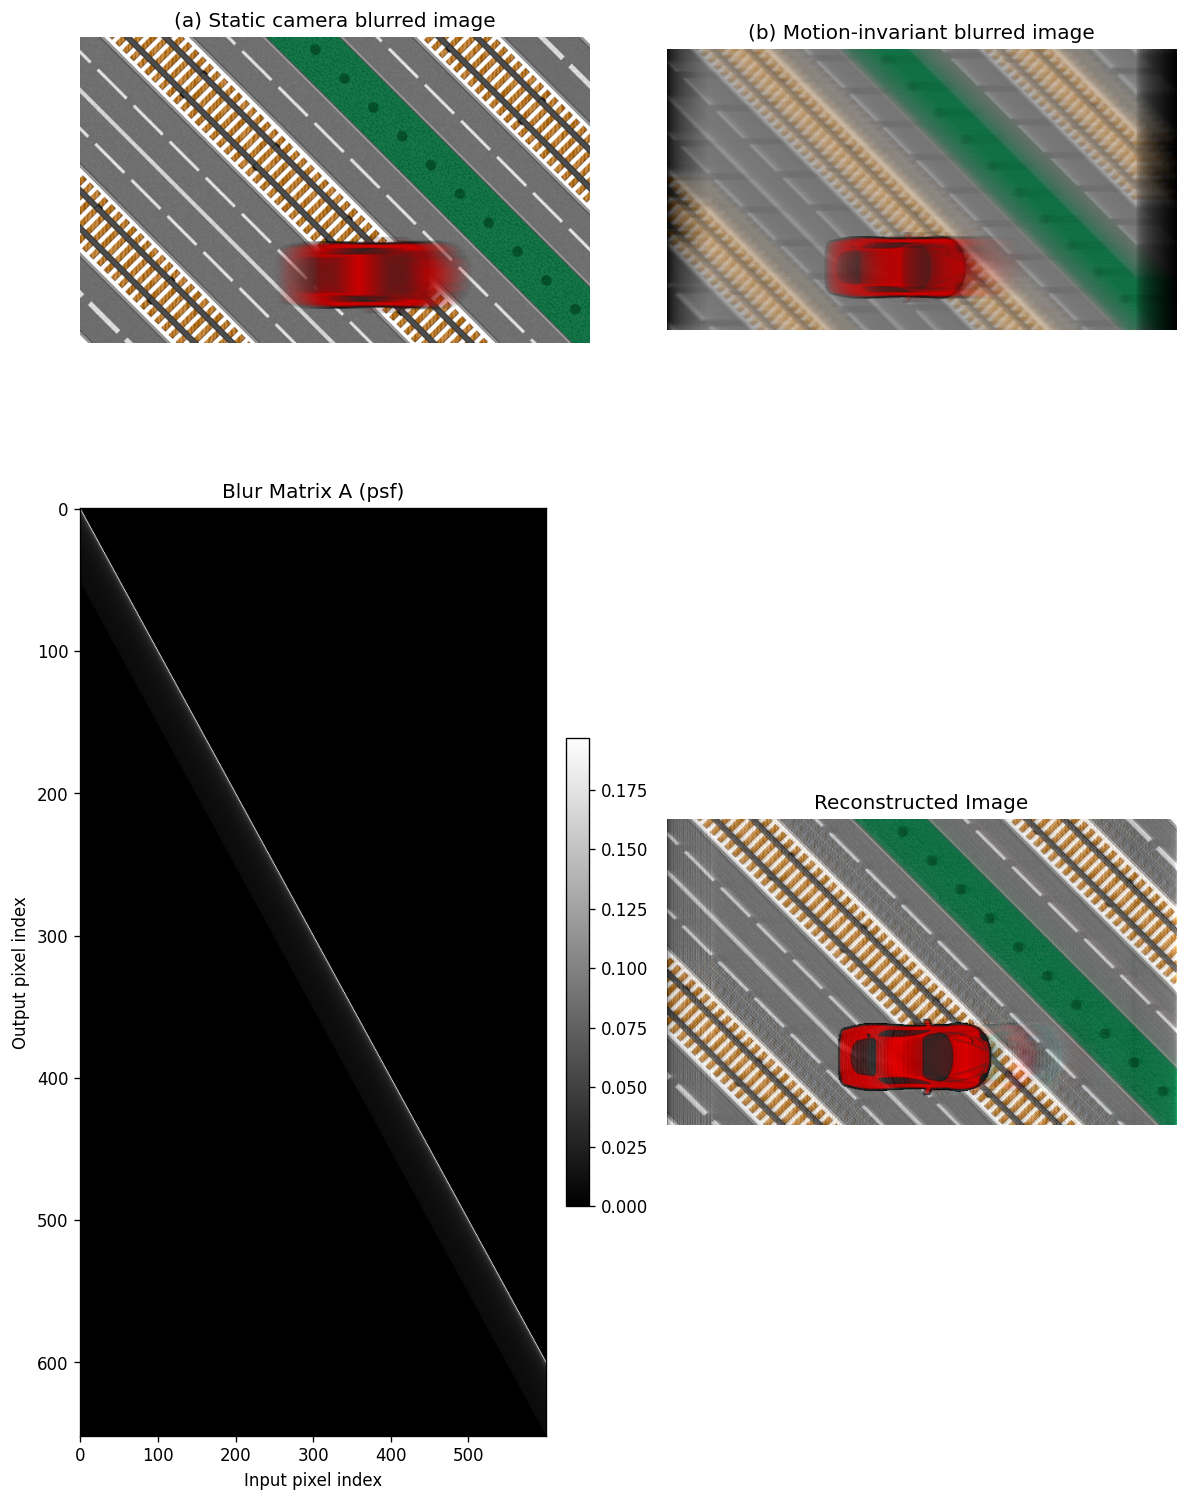

In [11]:
# Plotting in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 15))

# Clean image (top left)
axs[0, 0].imshow(blur_a.astype(np.uint8))
axs[0, 0].set_title("(a) Static camera blurred image")
axs[0, 0].axis('off')

# Blurred + noisy image (top right)
axs[0, 1].imshow(blur_b.astype(np.uint8))
axs[0, 1].set_title("(b) Motion-invariant blurred image")
axs[0, 1].axis('off')

# (b) Display A (visualization)
# Blur matrix A (bottom left)
im = axs[1, 0].imshow(A_psf, cmap='gray', aspect='auto')
axs[1, 0].set_title("Blur Matrix A (psf)")
axs[1, 0].set_xlabel("Input pixel index")
axs[1, 0].set_ylabel("Output pixel index")
plt.colorbar(im, ax=axs[1, 0], fraction=0.046, pad=0.04)

# Reconstructed image (bottom right)
axs[1, 1].imshow(np.clip(rec_b, 0, 255).astype(np.uint8))
axs[1, 1].set_title("Reconstructed Image")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

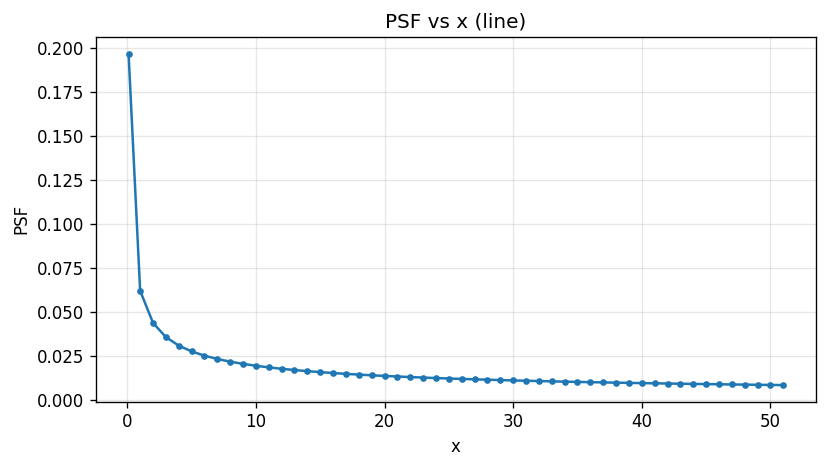

In [12]:
import matplotlib.pyplot as plt

# Line plot of PSF vs x
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x_vals, psf, marker='o', linewidth=1.5, markersize=3)
ax.set_xlabel('x')
ax.set_ylabel('PSF')
ax.set_title('PSF vs x (line)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Problem 3: Motion-invariant photography
(c) Static camera: moving object blurred; Motion-invariant: relative blur on object reduced; background shows camera-induced blur.
(d) PSF created and normalized.
(e) A_psf formed with shape: (652, 600)
blur_b shape =  (360, 652, 3)
psf shape =  (52,)
(f) Deblurring done for motion-invariant case.


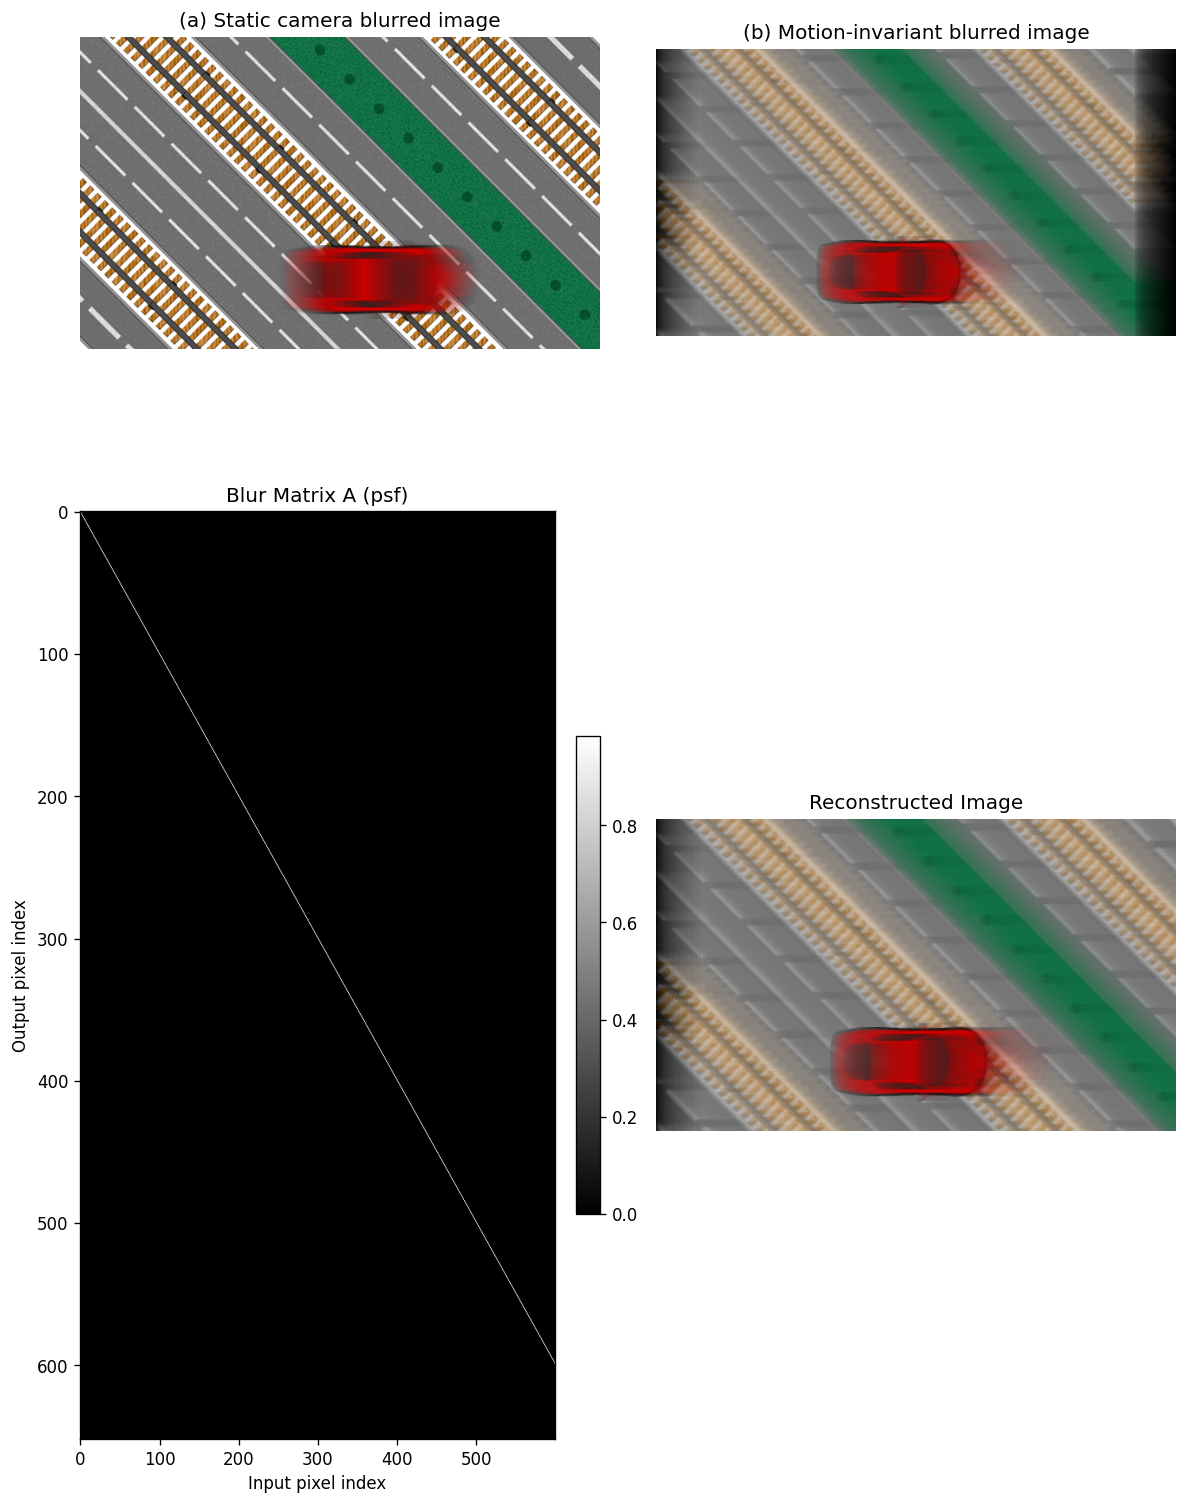

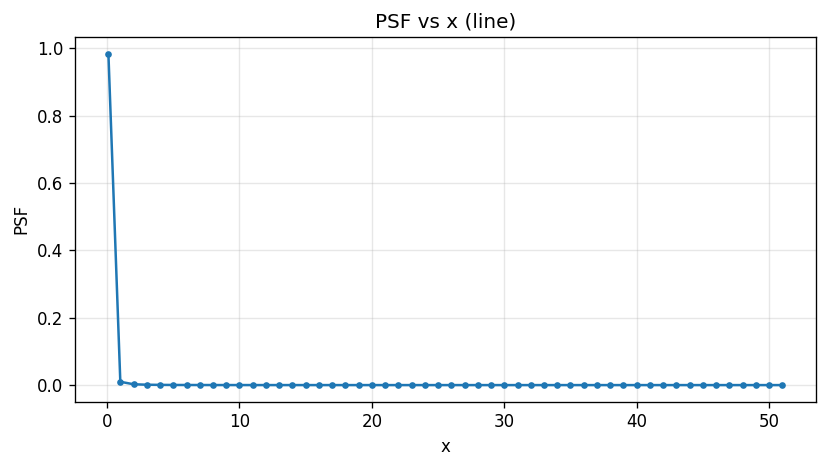

In [13]:
# ==============================================
# Problem 3: Deblurring with motion-invariant photography
# ==============================================
print("Problem 3: Motion-invariant photography")

H_bg, W_bg = background_img.shape[:2]
car_h, car_w = redcar_img.shape[:2]
car_start_x, car_start_y = 20, 100  # configurable placement

# (a) Static camera, object translates right at 1 px/sec
frames_a = []
for t in range(EXPOSURE_TIME):
    frame = background_img.astype(np.float64).copy()
    x = car_start_x + t
    y = car_start_y
    if x < W_bg and y < H_bg:
        x_end = min(W_bg, x + car_w)
        y_end = min(H_bg, y + car_h)
        fg_x_end = car_w - max(0, x + car_w - W_bg)
        fg_y_end = car_h - max(0, y + car_h - H_bg)
        if (x_end > x) and (y_end > y) and (fg_x_end > 0) and (fg_y_end > 0):
            fg = redcar_img[:fg_y_end, :fg_x_end, :]
            mask = np.any(fg > 0, axis=2)
            region = frame[y:y_end, x:x_end, :]
            region[mask] = fg[mask]
            frame[y:y_end, x:x_end, :] = region
    frames_a.append(frame)

blur_a = np.mean(frames_a, axis=0)

# (b) Motion-invariant: camera motion from CameraT.mat; background shifts by camera motion; 
# relative object translation = camera translation - object translation
frames_b = []

for t in range(EXPOSURE_TIME):
    dx_cam = float(cameraT[t])  # camera translation in pixels at time t

    # Create extended background canvas to allow shifting without cropping
    # We extend by EXPOSURE_TIME on both sides to avoid boundary issues
    pad_left = 52
    extended_width = W_bg + pad_left
    bg_extended = np.zeros((H_bg, extended_width, 3), dtype=np.float64)

    # Place original background in the center
    # Compute shift: positive dx_cam means camera moves right → background shifts right
    s = int(np.round(dx_cam))
    bg_extended[:, s:s + W_bg, :] = background_img

    # Now place the moving car with *relative motion*
    object_translation = t  # object moves at 1 px/sec
    relative_translation = dx_cam - object_translation
    x = int(np.round(car_start_x + relative_translation))
    y = car_start_y

    frame = bg_extended.copy()

    # Paste red car with bounds checking
    if x < W_bg and y < H_bg:
        x_end = min(W_bg, x + car_w)
        y_end = min(H_bg, y + car_h)

        fg_x_start = max(0, -x)
        fg_y_start = max(0, -y)
        fg_x_end = car_w - max(0, x + car_w - W_bg)
        fg_y_end = car_h - max(0, y + car_h - H_bg)

        if fg_x_end > fg_x_start and fg_y_end > fg_y_start:
            fg = redcar_img[fg_y_start:fg_y_end, fg_x_start:fg_x_end, :]
            mask = np.any(fg > 0, axis=2)
            frame_y_start = y + fg_y_start
            frame_x_start = x + fg_x_start
            region = frame[frame_y_start:frame_y_start + fg.shape[0],
                          frame_x_start:frame_x_start + fg.shape[1], :]
            region[mask] = fg[mask]
            frame[frame_y_start:frame_y_start + fg.shape[0],
                  frame_x_start:frame_x_start + fg.shape[1], :] = region

    frames_b.append(frame)

# Final blurred image via averaging
blur_b = np.mean(frames_b, axis=0)

# (c) Compare and comment
print("(c) Static camera: moving object blurred; Motion-invariant: relative blur on object reduced; background shows camera-induced blur.")

# (d) PSF weights: w(x) = 1/x^2 for x in {0.1, 1, 2, ..., 51}, normalize
x_vals = np.concatenate([[0.1], np.arange(1, 52)])
psf = 1.0 / (x_vals**2)
psf = psf / (psf.sum() + 1e-12)
print("(d) PSF created and normalized.")

# (e) Use PSF to form blur matrix A_psf
A_psf = blur_matrix_from_psf_1d(W_bg, psf)
print("(e) A_psf formed with shape:", A_psf.shape)

# (f) Deblur blur_b using least squares row-wise with A_psf
print("blur_b shape = ", blur_b.shape)
print("psf shape = ", psf.shape)
rec_b = deblur_rowwise_least_squares(blur_b, A_psf)
print("(f) Deblurring done for motion-invariant case.")

# Plotting in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 15))

# Clean image (top left)
axs[0, 0].imshow(blur_a.astype(np.uint8))
axs[0, 0].set_title("(a) Static camera blurred image")
axs[0, 0].axis('off')

# Blurred + noisy image (top right)
axs[0, 1].imshow(blur_b.astype(np.uint8))
axs[0, 1].set_title("(b) Motion-invariant blurred image")
axs[0, 1].axis('off')

# (b) Display A (visualization)
# Blur matrix A (bottom left)
im = axs[1, 0].imshow(A_psf, cmap='gray', aspect='auto')
axs[1, 0].set_title("Blur Matrix A (psf)")
axs[1, 0].set_xlabel("Input pixel index")
axs[1, 0].set_ylabel("Output pixel index")
plt.colorbar(im, ax=axs[1, 0], fraction=0.046, pad=0.04)

# Reconstructed image (bottom right)
axs[1, 1].imshow(np.clip(rec_b, 0, 255).astype(np.uint8))
axs[1, 1].set_title("Reconstructed Image")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Line plot of PSF vs x
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x_vals, psf, marker='o', linewidth=1.5, markersize=3)
ax.set_xlabel('x')
ax.set_ylabel('PSF')
ax.set_title('PSF vs x (line)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The correct form for motion invariant PSF is 1 / root(x) not 1 / x^2